# WEO Economic Data Analysis & Recession Prediction

**Objective:** Load World Economic Outlook (WEO) data, clean and transform it, then use machine learning models to predict global recessions.

**Workflow:**
1. Data loading and cleaning
2. Feature engineering and recession flagging
3. Exploratory data analysis
4. Model training with full and reduced feature sets (comparing 13 vs 5 features)
5. Economy-specific analysis (Upper vs Lower economies with both feature sets)
6. Future predictions for all scenarios

**Models Used:** Logistic Regression, Random Forest, Gradient Boosting, Linear SVM, Decision Tree, and Ensemble

In [1]:
# Core data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# File handling
import csv
from pathlib import Path

# Machine learning - preprocessing
from sklearn.preprocessing import StandardScaler

# Machine learning - models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Machine learning - metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

# Machine learning - model selection
from sklearn.model_selection import GridSearchCV

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False
    print("XGBoost not installed. Install with: pip install xgboost")

# LightGBM
try:
    from lightgbm import LGBMClassifier
    HAS_LIGHTGBM = True
except ImportError:
    HAS_LIGHTGBM = False
    print("LightGBM not installed. Install with: pip install lightgbm")

# Deep learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, LayerNormalization, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Optional pycountry for continent mapping
try:
    import pycountry
    import pycountry_convert as pc
    HAS_PYCOUNTRY = True
except ImportError:
    HAS_PYCOUNTRY = False

pd.set_option("display.max_rows", 25)


# 1. Data Loading

In [2]:
p = Path(r"data.csv")
if not p.exists():
    raise FileNotFoundError(p)

# Detect encoding and delimiter
encoding = "utf-8"
try:
    sample = p.read_text(encoding=encoding)[:8192]
except UnicodeDecodeError:
    encoding = "latin-1"
    sample = p.read_text(encoding=encoding)[:8192]

try:
    delim = csv.Sniffer().sniff(sample).delimiter
except Exception:
    delim = ","

df = pd.read_csv(p, sep=delim, encoding=encoding, low_memory=False, parse_dates=True)
print("Shape:", df.shape)
df.head()

Shape: (8626, 61)


,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2022,2023,2024,2025,2026,2027,2028,2029,2030,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,032.712","1,056.123",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,Units,"See notes for: Gross domestic product, consta...",NaN,...,-6.240,2.267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,283.442","1,350.910",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,14.501,17.248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,86.149,91.272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0


In [3]:
print(f"Number of columns: {df.shape[1]}")
print(f"Number of rows: {df.shape[0]}")
print("\nColumn names:", df.columns.tolist())

Number of columns: 61
Number of rows: 8626

Column names: ['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country', 'Subject Descriptor', 'Subject Notes', 'Units', 'Scale', 'Country/Series-specific Notes', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', 'Estimates Start After']


In [4]:
df.drop(columns=["WEO Country Code", "ISO", "Country/Series-specific Notes", "Subject Notes", 
                 "Units", "Scale", "Estimates Start After", "Subject Descriptor"], inplace=True)

codes = {
    # Core growth & external
    "NGDP_RPCH", "NGDPRPC", "PCPIPCH", "TX_RPCH", "TM_RPCH", "BCA_NGDPD",
    # Fiscal & debt aggregates
    "GGR_NGDP", "GGX_NGDP", "GGXWDN_NGDP", "GGXWDG_NGDP",
    # Savings & investment
    "NGSD_NGDP", "NID_NGDP",
    # Prices
    "PCPI", "LUR"
}

col = "WEO Subject Code"

if col not in df.columns:
    raise KeyError(f"Column {col!r} not found in dataframe")

df = df[df[col].astype(str).str.strip().isin(codes)].copy()
print("shape after filter:", df.shape)
df

shape after filter: (2744, 53)


,WEO Subject Code,Country,1980,1981,1982,1983,1984,1985,1986,1987,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
1,NGDP_RPCH,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-14.542,-6.240,2.267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NGDPRPC,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"27,467.825","25,101.133","25,044.069",NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NID_NGDP,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.987,16.668,15.244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NGSD_NGDP,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.931,-1.863,-5.062,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,PCPI,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,130.038,143.822,132.728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8608,GGR_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.348,16.599,14.649,16.581,18.549,18.698,19.117,19.197,19.277,19.277
8610,GGX_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.573,21.476,19.968,18.641,19.053,18.257,18.231,18.201,18.143,18.110
8618,GGXWDN_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8620,GGXWDG_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.172,99.536,96.586,94.587,58.568,56.051,53.294,52.315,50.485,48.312


## Data Reshaping: Wide to Long to Wide

In [5]:
year_cols = df.columns[2:]

df[year_cols] = df[year_cols].replace({',': ''}, regex=True)
df[year_cols] = df[year_cols].apply(pd.to_numeric, errors="coerce")

df["Country"] = (
    df["Country"]
    .str.replace(" ", "_")
    .str.replace("'", "")
    .str.replace("-", "_")
)

df_long = df.melt(id_vars=["WEO Subject Code", "Country"],
                  var_name="Year", value_name="Value")

df_long["Year"] = df_long["Year"].astype(str).str.strip()
df_long = df_long[df_long["Year"].str.fullmatch(r"\d{4}")].copy()
df_long["Year"] = df_long["Year"].astype(int)

df_long["Value"] = (
    df_long["Value"].astype(str)
    .str.replace(",", "")
    .replace({"": None, "nan": None})
    .astype(float)
)

df_pivot = df_long.pivot_table(
    index=["Country", "Year"],
    columns="WEO Subject Code",
    values="Value",
    aggfunc="first"
).reset_index()

df_pivot.columns.name = None
df_pivot = df_pivot.set_index("Year")

df_pivot

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,LUR,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH
Year,,,,,,,,,,,,,,,
2002,Afghanistan,33.908,6.845,345.977,NaN,6.943,NaN,21594.230,NaN,61.151,27.243,31.263,NaN,NaN,NaN
2003,Afghanistan,29.616,9.826,270.602,NaN,11.927,NaN,21766.381,8.692,59.718,30.102,42.413,35.663,36.222,49.541
2004,Afghanistan,37.216,12.676,244.967,NaN,15.069,NaN,21067.277,0.671,72.570,35.354,49.351,16.358,-0.427,-8.436
2005,Afghanistan,30.226,14.733,206.356,NaN,15.651,NaN,22731.779,11.830,67.274,37.048,54.566,10.569,55.010,41.968
2006,Afghanistan,20.844,18.946,22.985,NaN,18.262,NaN,22979.189,5.361,50.333,29.489,58.269,6.785,-2.198,-6.919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,Zimbabwe,3.063,18.698,56.051,NaN,18.257,NaN,6.061,4.640,NaN,NaN,1204688.561,9.627,NaN,NaN
2027,Zimbabwe,2.927,19.117,53.294,NaN,18.231,NaN,6.150,3.630,NaN,NaN,1300690.916,7.969,NaN,NaN
2028,Zimbabwe,2.895,19.197,52.315,NaN,18.201,NaN,6.231,3.458,NaN,NaN,1404343.758,7.969,NaN,NaN


# 3. Feature Engineering

## Add Recession Target Variable

In [6]:
# --- Step 1: Ensure chronological order ---
df_pivot = df_pivot.sort_index()

# --- Step 2: Construct diagnostic flags (not stored in df) ---

# 1. GDP-based recession (two consecutive annual declines)
flag_gdp = (
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0)) &
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change().shift(-1) < 0))
).astype(int)

# 2. Investment collapse (sharp drop in investment)
flag_invest = (
    df_pivot.groupby("Country")["NID_NGDP"].transform(lambda x: x.diff() < -2)
).astype(int)

# 3. Savings decline (household/national savings falling)
flag_savings = (
    df_pivot.groupby("Country")["NGSD_NGDP"].transform(lambda x: x.diff() < -2)
).astype(int)

# 4. Trade shock (both exports and imports contracting)
flag_trade = (
    (df_pivot.groupby("Country")["TX_RPCH"].transform(lambda x: x < 0)) &
    (df_pivot.groupby("Country")["TM_RPCH"].transform(lambda x: x < 0))
).astype(int)

# 5. Inflation shock (stagflation: high inflation + negative growth)
flag_inflation = (
    (df_pivot.groupby("Country")["PCPIPCH"].transform(lambda x: x > 10)) &
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0))
).astype(int)

# 6. Debt crisis (gross debt rising sharply above 90% of GDP)
flag_debt = (
    (df_pivot["GGXWDG_NGDP"] > 90) &
    (df_pivot.groupby("Country")["GGXWDG_NGDP"].transform(lambda x: x.diff() > 10))
).astype(int)

# 7. Fiscal crisis (large and growing deficit)
flag_fiscal = (
    (df_pivot.groupby("Country")["GGR_NGDP"].transform(lambda x: x) < 
     df_pivot.groupby("Country")["GGX_NGDP"].transform(lambda x: x) - 5) &  # Deficit > 5% GDP
    (df_pivot.groupby("Country")["GGX_NGDP"].transform(lambda x: x.diff()) > 2)  # Rising spending
).astype(int)

# 8. Current account crisis (large deficit deteriorating)
flag_current_account = (
    (df_pivot["BCA_NGDPD"] < -5) &  # Deficit > 5% of GDP
    (df_pivot.groupby("Country")["BCA_NGDPD"].transform(lambda x: x.diff() < -2))  # Worsening
).astype(int)

# 9. Real GDP growth collapse (severe contraction)
flag_growth_collapse = (
    df_pivot.groupby("Country")["NGDP_RPCH"].transform(lambda x: x < -3)  # Growth < -3%
).astype(int)

# 10. Deflation risk (falling prices with economic weakness)
flag_deflation = (
    (df_pivot.groupby("Country")["PCPIPCH"].transform(lambda x: x < 0)) &  # Negative inflation
    (df_pivot.groupby("Country")["NGDP_RPCH"].transform(lambda x: x < 1))  # Weak growth
).astype(int)

# 11. Credit crunch (investment falling while debt rising)
flag_credit_crunch = (
    (df_pivot.groupby("Country")["NID_NGDP"].transform(lambda x: x.diff() < -1)) &
    (df_pivot.groupby("Country")["GGXWDG_NGDP"].transform(lambda x: x.diff() > 5))
).astype(int)

# 12. External shock (exports collapsing while imports stable/rising)
flag_external_shock = (
    (df_pivot.groupby("Country")["TX_RPCH"].transform(lambda x: x < -5)) &
    (df_pivot.groupby("Country")["TM_RPCH"].transform(lambda x: x > -2))
).astype(int)

# --- Step 3: Combine signals into a single severity score ---
local_signal_count = (
    flag_gdp + 
    flag_invest + 
    flag_savings + 
    flag_trade + 
    flag_inflation +
    flag_debt +
    flag_fiscal +
    flag_current_account +
    flag_growth_collapse +
    flag_deflation +
    flag_credit_crunch +
    flag_external_shock
)

# --- Step 4: Multiclass recession risk label ---
def classify_risk(local_count):
    """
    Same thresholds as original:
    - 3+ signals: High risk
    - 2 signals: Moderate risk  
    - 1 signal: Mild risk
    - 0 signals: No risk
    """
    if local_count >= 4:
        return 3  # High risk
    if local_count == 2 or local_count == 3:
        return 2  # Moderate risk
    if local_count == 1:
        return 1  # Mild risk
    return 0      # No risk

df_pivot["RecessionRisk"] = [
    classify_risk(l) for l in local_signal_count
]

# Store signal count
df_pivot["SignalCount"] = local_signal_count

# --- Step 5: Fill NaN with mean instead of dropping ---
# Fill numeric columns with their mean
numeric_cols = df_pivot.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df_pivot[col] = df_pivot[col].fillna(df_pivot[col].mean())

# Fill non-numeric columns with forward fill or mode
non_numeric_cols = df_pivot.select_dtypes(exclude=[np.number]).columns
for col in non_numeric_cols:
    if col == 'Country':
        continue  # Don't fill Country column
    df_pivot[col] = df_pivot[col].fillna(method='ffill').fillna(method='bfill')

df_pivot = df_pivot.sort_index(ascending=True)

# --- Step 6: Show distribution ---
print("=" * 70)
print("RECESSION RISK CLASSIFICATION SUMMARY (12 Indicators)")
print("=" * 70)

print("\nRecessionRisk class distribution:")
print(df_pivot["RecessionRisk"].value_counts().sort_index())
print(f"\nTotal samples: {len(df_pivot)}")

# Show average signals per risk class
print("\n" + "=" * 70)
print("AVERAGE SIGNALS TRIGGERED PER RISK CLASS:")
print("=" * 70)

signal_summary = df_pivot.groupby('RecessionRisk')['SignalCount'].agg(['mean', 'min', 'max', 'count'])
print(signal_summary)

# Show which signals are most common
print("\n" + "=" * 70)
print("INDIVIDUAL SIGNAL FREQUENCIES:")
print("=" * 70)

# Recalculate flags for cleaned data
flag_gdp_clean = (
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0)) &
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change().shift(-1) < 0))
).astype(int)

flag_invest_clean = (
    df_pivot.groupby("Country")["NID_NGDP"].transform(lambda x: x.diff() < -2)
).astype(int)

flag_savings_clean = (
    df_pivot.groupby("Country")["NGSD_NGDP"].transform(lambda x: x.diff() < -2)
).astype(int)

flag_trade_clean = (
    (df_pivot.groupby("Country")["TX_RPCH"].transform(lambda x: x < 0)) &
    (df_pivot.groupby("Country")["TM_RPCH"].transform(lambda x: x < 0))
).astype(int)

flag_inflation_clean = (
    (df_pivot.groupby("Country")["PCPIPCH"].transform(lambda x: x > 10)) &
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0))
).astype(int)

flag_debt_clean = (
    (df_pivot["GGXWDG_NGDP"] > 90) &
    (df_pivot.groupby("Country")["GGXWDG_NGDP"].transform(lambda x: x.diff() > 10))
).astype(int)

flag_fiscal_clean = (
    (df_pivot.groupby("Country")["GGR_NGDP"].transform(lambda x: x) < 
     df_pivot.groupby("Country")["GGX_NGDP"].transform(lambda x: x) - 5) &
    (df_pivot.groupby("Country")["GGX_NGDP"].transform(lambda x: x.diff()) > 2)
).astype(int)

flag_current_account_clean = (
    (df_pivot["BCA_NGDPD"] < -5) &
    (df_pivot.groupby("Country")["BCA_NGDPD"].transform(lambda x: x.diff() < -2))
).astype(int)

flag_growth_collapse_clean = (
    df_pivot.groupby("Country")["NGDP_RPCH"].transform(lambda x: x < -3)
).astype(int)

flag_deflation_clean = (
    (df_pivot.groupby("Country")["PCPIPCH"].transform(lambda x: x < 0)) &
    (df_pivot.groupby("Country")["NGDP_RPCH"].transform(lambda x: x < 1))
).astype(int)

flag_credit_crunch_clean = (
    (df_pivot.groupby("Country")["NID_NGDP"].transform(lambda x: x.diff() < -1)) &
    (df_pivot.groupby("Country")["GGXWDG_NGDP"].transform(lambda x: x.diff() > 5))
).astype(int)

flag_external_shock_clean = (
    (df_pivot.groupby("Country")["TX_RPCH"].transform(lambda x: x < -5)) &
    (df_pivot.groupby("Country")["TM_RPCH"].transform(lambda x: x > -2))
).astype(int)

signal_names = [
    'GDP Decline', 'Investment Collapse', 'Savings Decline', 'Trade Shock',
    'Inflation Shock', 'Debt Crisis', 'Fiscal Crisis', 'Current Account Crisis',
    'Growth Collapse', 'Deflation Risk', 'Credit Crunch', 'External Shock'
]

signals_clean = [
    flag_gdp_clean, flag_invest_clean, flag_savings_clean, flag_trade_clean, 
    flag_inflation_clean, flag_debt_clean, flag_fiscal_clean, flag_current_account_clean,
    flag_growth_collapse_clean, flag_deflation_clean, flag_credit_crunch_clean, 
    flag_external_shock_clean
]

for name, signal in zip(signal_names, signals_clean):
    count = signal.sum()
    pct = (count / len(df_pivot)) * 100
    print(f"{name:<25} {count:>5} ({pct:>5.2f}%)")

print("\n" + "=" * 70)

# Remove temporary column
df_pivot = df_pivot.drop(columns=['SignalCount'])

# --- Output: dataframe with multiclass label ---
df_pivot

C:\Users\ningw\AppData\Local\Temp\ipykernel_25352\1118516605.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0)) &
C:\Users\ningw\AppData\Local\Temp\ipykernel_25352\1118516605.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change().shift(-1) < 0))
C:\Users\ningw\AppData\Local\Temp\ipykernel_25352\1118516605.py:31: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill i

RECESSION RISK CLASSIFICATION SUMMARY (12 Indicators)

RecessionRisk class distribution:
RecessionRisk
0    4702
1    2080
2    1809
3     618
Name: count, dtype: int64

Total samples: 9209

AVERAGE SIGNALS TRIGGERED PER RISK CLASS:
                   mean  min  max  count
RecessionRisk                           
0              0.000000    0    0   4702
1              1.000000    1    1   2080
2              2.333333    2    3   1809
3              4.731392    4    9    618

INDIVIDUAL SIGNAL FREQUENCIES:
GDP Decline                1055 (11.46%)
Investment Collapse        1502 (16.31%)
Savings Decline            1573 (17.08%)
Trade Shock                1137 (12.35%)
Inflation Shock             714 ( 7.75%)
Debt Crisis                 205 ( 2.23%)
Fiscal Crisis               515 ( 5.59%)
Current Account Crisis     1005 (10.91%)
Growth Collapse             655 ( 7.11%)
Deflation Risk              173 ( 1.88%)
Credit Crunch               361 ( 3.92%)
External Shock              518 ( 5.62

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,LUR,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,RecessionRisk
Year,,,,,,,,,,,,,,,,
1980,Philippines,-5.135,28.885018,56.173166,43.869771,31.637437,8.615541,92589.626,5.149,17.114000,23.435000,6.258000e+00,18.201000,3.723000,15.287000,0
1980,Algeria,0.526,28.885018,56.173166,43.869771,31.637437,15.789000,150958.885,-5.400,28.040000,36.058000,8.975000e+00,9.668000,5.047000,-14.588000,2
1980,Albania,0.053,28.885018,56.173166,43.869771,31.637437,5.028000,238341.384,2.684,26.802000,5.349000,1.107572e+11,37.137608,0.000000,0.000000,0
1980,Solomon_Islands,-3.109,24.319000,56.173166,43.869771,20.897000,8.615541,17176.953,-2.663,7.122000,3.650000,4.221000e+00,8.250000,14.100000,3.021000,0
1980,Cyprus,-11.164,28.885018,56.173166,43.869771,31.637437,8.615541,9448.317,5.920,28.651000,49.258000,3.216300e+01,13.518000,4.353000,9.317000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,Tajikistan,-2.240,27.489000,29.198000,43.869771,29.750000,8.615541,51.568,4.500,20.603000,22.843000,2.922129e+03,6.500000,0.000000,0.000000,0
2030,Tanzania,-2.477,16.460000,40.381000,43.869771,19.135000,8.615541,2904355.925,6.196,39.159000,41.636000,5.395380e+02,4.001000,8.475000,3.836000,0
2030,The_Gambia,-0.561,20.622000,44.413000,43.869771,20.980000,8.615541,31800.257,5.002,20.780000,21.340000,1.210157e+03,5.000000,0.647000,7.557000,0


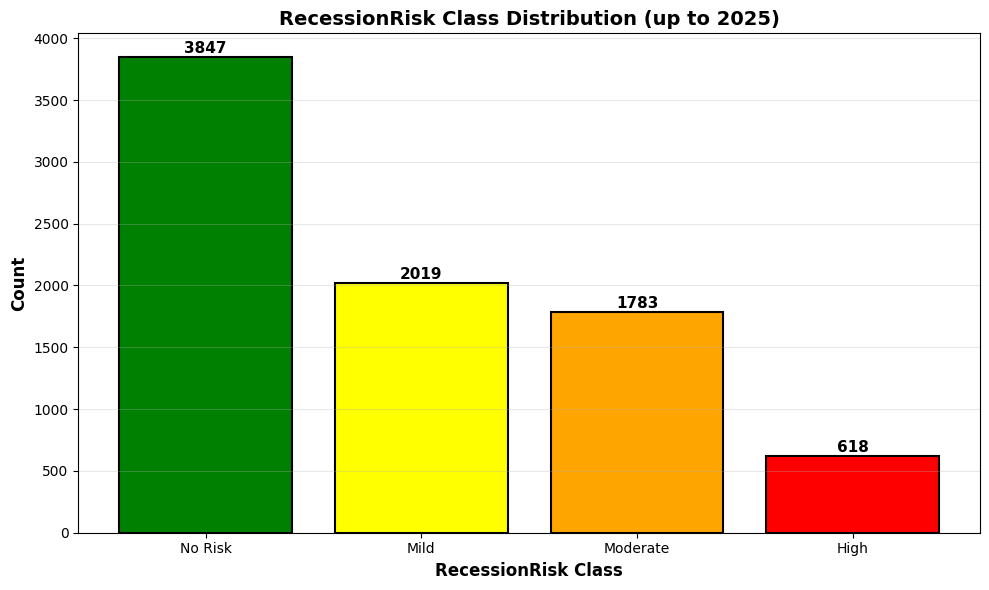

Total samples (up to 2025): 8267


In [7]:
# RecessionRisk Class Distribution - Compact Plot (up to 2025)
df_until_2025 = df_pivot[df_pivot.index <= 2025]
risk_counts = df_until_2025["RecessionRisk"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
colors = ['green', 'yellow', 'orange', 'red']
plt.bar(risk_counts.index, risk_counts.values, color=colors, edgecolor='black', linewidth=1.5)
plt.xlabel('RecessionRisk Class', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('RecessionRisk Class Distribution (up to 2025)', fontsize=14, fontweight='bold')
plt.xticks([0, 1, 2, 3], ['No Risk', 'Mild', 'Moderate', 'High'])
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for cls, count in risk_counts.items():
    plt.text(cls, count + 10, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Total samples (up to 2025): {len(df_until_2025)}")

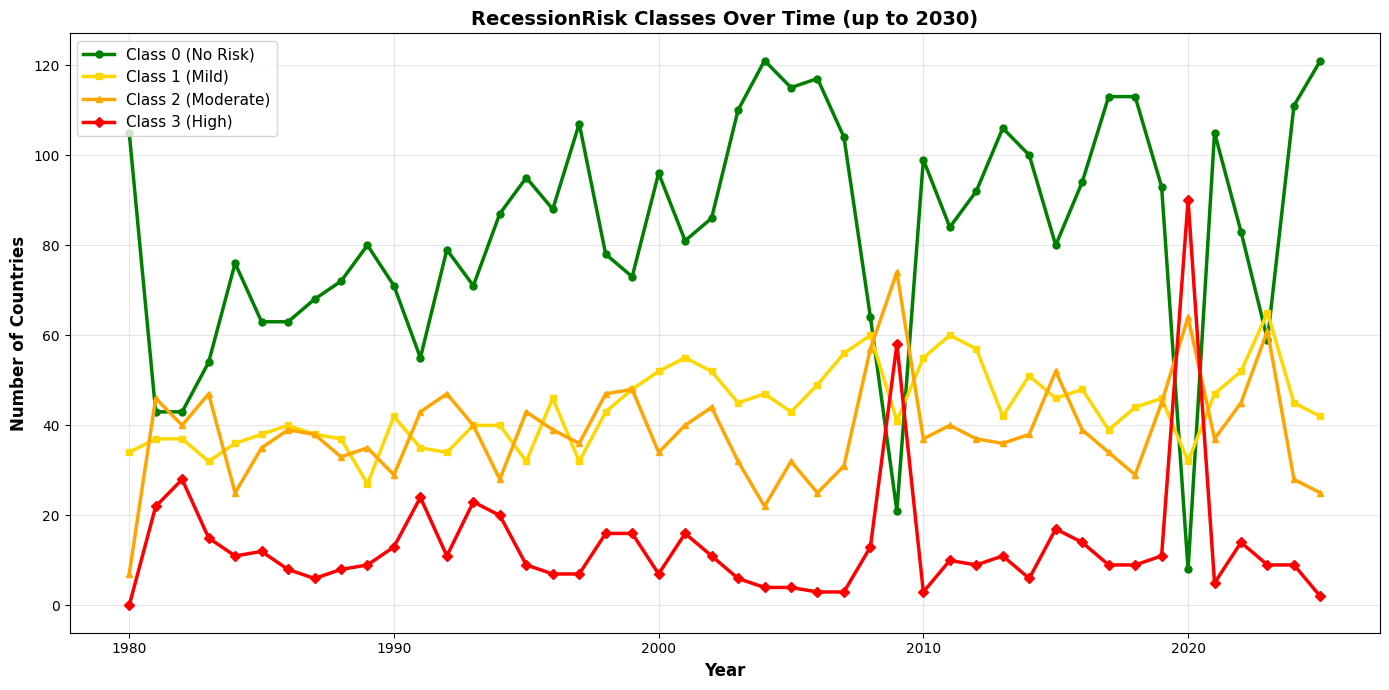

In [8]:
# All RecessionRisk Classes by Year - Line Graph (up to 2025)
# Calculate counts for each class by year
df0 = df_until_2025[df_until_2025["RecessionRisk"] == 0].copy()
df1 = df_until_2025[df_until_2025["RecessionRisk"] == 1].copy()
df2 = df_until_2025[df_until_2025["RecessionRisk"] == 2].copy()
df3 = df_until_2025[df_until_2025["RecessionRisk"] == 3].copy()

class0_by_year = df0.groupby(df0.index).size()
class1_by_year = df1.groupby(df1.index).size()
class2_by_year = df2.groupby(df2.index).size()
class3_by_year = df3.groupby(df3.index).size()

# Get all years (up to 2025)
all_years = sorted(df_until_2025.index.unique())

# Reindex to include all years (fill missing with 0)
class0_by_year = class0_by_year.reindex(all_years, fill_value=0)
class1_by_year = class1_by_year.reindex(all_years, fill_value=0)
class2_by_year = class2_by_year.reindex(all_years, fill_value=0)
class3_by_year = class3_by_year.reindex(all_years, fill_value=0)

plt.figure(figsize=(14, 7))
plt.plot(all_years, class0_by_year.values, color='green', linewidth=2.5, marker='o', label='Class 0 (No Risk)', markersize=5)
plt.plot(all_years, class1_by_year.values, color='gold', linewidth=2.5, marker='s', label='Class 1 (Mild)', markersize=5)
plt.plot(all_years, class2_by_year.values, color='orange', linewidth=2.5, marker='^', label='Class 2 (Moderate)', markersize=5)
plt.plot(all_years, class3_by_year.values, color='red', linewidth=2.5, marker='D', label='Class 3 (High)', markersize=5)

plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Number of Countries', fontsize=12, fontweight='bold')
plt.title('RecessionRisk Classes Over Time (up to 2030)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Cutting Out Data that leads to biasness & Review Remaining Countries

In [9]:
df_filtered = df_pivot.loc[(df_pivot.index >= 2000) & (df_pivot.index <= 2025)]
df_filtered

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,LUR,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,RecessionRisk
Year,,,,,,,,,,,,,,,,
2000,Togo,-6.956,8.456000,56.173166,43.869771,11.901000,8.615541,4.024883e+05,-0.970,3.674000,10.630000,7.139700e+01,1.567,-10.349000,-10.852000,2
2000,Zimbabwe,2.838,28.885018,56.173166,43.869771,31.637437,8.615541,7.322000e+00,-4.231,20.686686,24.154875,1.000000e+02,4.475,5.351302,5.552211,2
2000,Indonesia,4.452,13.433000,87.437000,43.869771,15.303000,6.080000,1.967490e+07,4.979,24.905000,25.087000,2.709000e+01,3.688,25.495000,17.851000,0
2000,France,1.103,51.306000,59.721000,50.654000,52.622000,9.175000,3.219452e+04,4.364,22.961000,21.858000,7.822600e+01,1.815,15.609000,13.266000,0
2000,Chad,-10.479,9.355000,52.407000,43.869771,14.036000,8.615541,3.292346e+05,-0.880,10.265000,20.744000,6.534100e+01,3.823,3.110000,5.394000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025,Tonga,-6.947,41.769000,44.128000,43.869771,49.670000,8.615541,1.099938e+04,2.725,20.686686,24.154875,1.317410e+02,3.570,5.351302,5.552211,1
2025,Venezuela,-0.067,28.885018,56.173166,43.869771,31.637437,8.615541,2.238718e+06,-4.000,20.686686,24.154875,7.632536e+11,180.001,-15.518000,-7.966000,2
2025,Cyprus,-7.265,44.195000,60.282000,25.732000,40.357000,4.773000,3.036760e+04,2.545,13.390000,20.655000,1.197320e+02,2.272,4.660000,4.186000,0


In [10]:
print(df_filtered["Country"].unique())


['Togo' 'Zimbabwe' 'Indonesia' 'France' 'Chad' 'Slovenia' 'India'
 'Vietnam' 'Germany' 'Sri_Lanka' 'Libya' 'Algeria' 'Angola' 'Liberia'
 'Belize' 'Mozambique' 'Dominican_Republic' 'Benin' 'Ecuador' 'Tanzania'
 'Kenya' 'St._Vincent_and_the_Grenadines' 'Mauritania' 'Oman' 'Armenia'
 'Fiji' 'Lao_P.D.R.' 'Ethiopia' 'Greece' 'United_Arab_Emirates' 'Bhutan'
 'Senegal' 'Colombia' 'Mali' 'Netherlands' 'China' 'Belgium' 'Seychelles'
 'Tonga' 'West_Bank_and_Gaza' 'Singapore' 'Nepal' 'Pakistan' 'Madagascar'
 'Burundi' 'Türkiye' 'Cabo_Verde' 'Hungary' 'Myanmar' 'Kazakhstan'
 'Guyana' 'Bolivia' 'Belarus' 'Egypt' 'Guinea_Bissau' 'Aruba' 'The_Gambia'
 'St._Kitts_and_Nevis' 'Eswatini' 'Ukraine' 'Tajikistan'
 'Bosnia_and_Herzegovina' 'Argentina' 'Finland' 'Lithuania' 'Latvia'
 'Papua_New_Guinea' 'Dominica' 'United_States' 'South_Africa' 'Uganda'
 'Barbados' 'Kiribati' 'Republic_of_Congo' 'Turkmenistan' 'Thailand'
 'Croatia' 'Haiti' 'Solomon_Islands' 'Israel' 'Cyprus' 'Jordan'
 'Trinidad_and_Tobago' 'Dj

In [11]:
df_filtered["Country"].nunique()


196

# 4. Exploratory Data Analysis

## Correlation Heatmap

## Prepare Features and Target

In [12]:
X = df_filtered.drop(columns=["RecessionRisk", "Country"])
y = df_filtered["RecessionRisk"]

# 5. Machine Learning Models

## Global Dataset - Full Features (13 Features)

### Define and Train All Models

In [13]:
# ============================================================
#             TRAIN ALL MODELS (MULTICLASS) - IMPROVED
# ============================================================
def train_all_models(X_train, y_train, X_val, y_val, X_test, y_test, model_params=None, use_xgb=False):
    """
    Enhanced model training with validation support.
    """
    if model_params is None:
        model_params = {
            'logit': {
                'C': 0.3,
                'penalty': 'l2',
                'solver': 'saga',
                'max_iter': 10000,
                'random_state': 42,
                'class_weight': 'balanced'
            },
            'rf': {
                'n_estimators': 200,
                'max_depth': 5,
                'min_samples_leaf': 20,
                'min_samples_split': 40,
                'max_features': 'sqrt',
                'random_state': 42,
                'class_weight': 'balanced',
                'n_jobs': -1,
                'max_samples': 0.8
            },
            'gb': {
                'n_estimators': 150,
                'learning_rate': 0.03,
                'max_depth': 3,
                'min_samples_leaf': 25,
                'min_samples_split': 50,
                'subsample': 0.7,
                'max_features': 'sqrt',
                'random_state': 42,
                'validation_fraction': 0.1,
                'n_iter_no_change': 20,
                'tol': 0.0001
            },
            'dt': {
                'max_depth': 4,
                'min_samples_leaf': 30,
                'min_samples_split': 60,
                'random_state': 42,
                'class_weight': 'balanced',
                'ccp_alpha': 0.001
            },
            'svm': {
                'C': 0.5,
                'kernel': 'rbf',
                'gamma': 'scale',
                'probability': True,
                'random_state': 42,
                'decision_function_shape': 'ovr',
                'class_weight': 'balanced'
            },
            'xgb': {
                'n_estimators': 150,
                'learning_rate': 0.05,
                'max_depth': 3,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'reg_alpha': 0.5,
                'reg_lambda': 2.0,
                'min_child_weight': 3,
                'random_state': 42,
                'objective': 'multi:softprob',
                'num_class': len(np.unique(y_train)),
                'tree_method': 'hist',
                'early_stopping_rounds': 20
            },
            'lgb': {
                'n_estimators': 150,
                'learning_rate': 0.05,
                'max_depth': 5,
                'num_leaves': 31,
                'min_child_samples': 20,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'reg_alpha': 0.3,
                'reg_lambda': 1.0,
                'random_state': 42,
                'objective': 'multiclass',
                'num_class': len(np.unique(y_train)),
                'verbose': -1
            }
        }

    # ----------------- SMOTE -----------------
    smote_kwargs = {'random_state': 42, 'k_neighbors': 3}

    logit = ImbPipeline([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(**smote_kwargs)),
        ("logit", LogisticRegression(**model_params['logit']))
    ]).fit(X_train, y_train)

    rf = ImbPipeline([
        ("smote", SMOTE(**smote_kwargs)),
        ("rf", RandomForestClassifier(**model_params['rf']))
    ]).fit(X_train, y_train)

    gb = ImbPipeline([
        ("smote", SMOTE(**smote_kwargs)),
        ("gb", GradientBoostingClassifier(**model_params['gb']))
    ]).fit(X_train, y_train)

    dt = ImbPipeline([
        ("smote", SMOTE(**smote_kwargs)),
        ("dt", DecisionTreeClassifier(**model_params['dt']))
    ]).fit(X_train, y_train)

    svm = ImbPipeline([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(**smote_kwargs)),
        ("svm", SVC(**model_params['svm']))
    ]).fit(X_train, y_train)

    models = {
        "Logistic Regression": logit,
        "Random Forest": rf,
        "Gradient Boosting": gb,
        "Decision Tree": dt,
        "SVM": svm,
    }

    # XGBoost (optional)
    if use_xgb and HAS_XGBOOST:
        xgb = ImbPipeline([
            ("smote", SMOTE(**smote_kwargs)),
            ("xgb", XGBClassifier(**model_params['xgb']))
        ]).fit(X_train, y_train)
        models["XGBoost"] = xgb

    # LightGBM (if available)
    if HAS_LIGHTGBM:
        lgb = ImbPipeline([
            ("smote", SMOTE(**smote_kwargs)),
            ("lgb", LGBMClassifier(**model_params['lgb']))
        ]).fit(X_train, y_train)
        models["LightGBM"] = lgb

    # ----------------- Ensemble -----------------
    ensemble_estimators = [
        ("rf", rf.named_steps["rf"]),
        ("gb", gb.named_steps["gb"]),
        ("svm", svm.named_steps["svm"]),
        ("logit", logit.named_steps["logit"])
    ]
    ensemble_weights = [2, 2, 1, 1]

    if use_xgb and HAS_XGBOOST:
        ensemble_estimators.append(("xgb", xgb.named_steps["xgb"]))
        ensemble_weights.append(2)

    if HAS_LIGHTGBM:
        ensemble_estimators.append(("lgb", lgb.named_steps["lgb"]))
        ensemble_weights.append(2)

    ensemble = VotingClassifier(
        estimators=ensemble_estimators,
        voting="soft",
        weights=ensemble_weights
    )
    ensemble.fit(X_train, y_train)
    models["Ensemble (Weighted)"] = ensemble

    # ----------------- Metrics -----------------
    results = {}
    confusion_mats = {}

    for name, m in models.items():
        y_pred_train = m.predict(X_train)
        y_pred_val = m.predict(X_val)
        y_pred_test = m.predict(X_test)

        results[name] = {
            "Train Accuracy": accuracy_score(y_train, y_pred_train),
            "Val Accuracy": accuracy_score(y_val, y_pred_val),
            "Test Accuracy": accuracy_score(y_test, y_pred_test),
            "Val F1 (macro)": f1_score(y_val, y_pred_val, average="macro", zero_division=0),
            "Test F1 (macro)": f1_score(y_test, y_pred_test, average="macro", zero_division=0),
            "Val F1 (weighted)": f1_score(y_val, y_pred_val, average="weighted", zero_division=0),
            "Test F1 (weighted)": f1_score(y_test, y_pred_test, average="weighted", zero_division=0),
        }

        confusion_mats[name] = {
            "val": confusion_matrix(y_val, y_pred_val),
            "test": confusion_matrix(y_test, y_pred_test)
        }

    results_df = pd.DataFrame(results).T
    return models, results_df, confusion_mats

# ============================================================
def plot_feature_importance(models, feature_names, title_prefix="", top_n=15):
    """
    Display feature importance with improved visualization.
    top_n: Show only top N most important features
    """
    logit = models.get("Logistic Regression")
    rf = models.get("Random Forest")
    gb = models.get("Gradient Boosting")
    dt = models.get("Decision Tree")

    coef_matrix = logit.named_steps['logit'].coef_
    coef_mean_abs = np.mean(np.abs(coef_matrix), axis=0)

    logit_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": coef_mean_abs
    }).sort_values("Importance", ascending=False).head(top_n)

    rf_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": rf.named_steps['rf'].feature_importances_
    }).sort_values("Importance", ascending=False).head(top_n)

    gb_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": gb.named_steps['gb'].feature_importances_
    }).sort_values("Importance", ascending=False).head(top_n)

    dt_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": dt.named_steps['dt'].feature_importances_
    }).sort_values("Importance", ascending=False).head(top_n)

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Sort in ascending order for better visualization
    logit_sorted = logit_importance.sort_values("Importance")
    rf_sorted = rf_importance.sort_values("Importance")
    gb_sorted = gb_importance.sort_values("Importance")
    dt_sorted = dt_importance.sort_values("Importance")

    axes[0, 0].barh(logit_sorted["Feature"], logit_sorted["Importance"], color='steelblue')
    axes[0, 0].set_title(f"{title_prefix}Logistic Regression (Top {top_n})", fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel("Mean |Coefficient|")

    axes[0, 1].barh(rf_sorted["Feature"], rf_sorted["Importance"], color='forestgreen')
    axes[0, 1].set_title(f"{title_prefix}Random Forest (Top {top_n})", fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel("Feature Importance")

    axes[1, 0].barh(gb_sorted["Feature"], gb_sorted["Importance"], color='darkorange')
    axes[1, 0].set_title(f"{title_prefix}Gradient Boosting (Top {top_n})", fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel("Feature Importance")

    axes[1, 1].barh(dt_sorted["Feature"], dt_sorted["Importance"], color='crimson')
    axes[1, 1].set_title(f"{title_prefix}Decision Tree (Top {top_n})", fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel("Feature Importance")

    plt.tight_layout()
    plt.show()


# ============================================================
#             CONFUSION MATRIX DISPLAY (MULTICLASS)
# ============================================================
def show_confusion_matrices(confusion_mats, results_df):
    """
    Display a separate confusion matrix figure for each model.
    Each figure contains:
        - Left: Validation confusion matrix
        - Right: Test confusion matrix
    """

    for model_name, cms in confusion_mats.items():

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # -------------------------
        # VALIDATION
        # -------------------------
        cm_val = cms["val"]
        disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
        disp_val.plot(cmap="Blues", ax=axes[0], colorbar=False)

        acc_val = results_df.loc[model_name, "Val Accuracy"]
        f1_val = results_df.loc[model_name, "Val F1 (macro)"]

        axes[0].set_title(
            f"{model_name} — Validation\nAcc={acc_val:.3f} | F1_macro={f1_val:.3f}",
            fontsize=11, fontweight="bold"
        )

        # -------------------------
        # TEST
        # -------------------------
        cm_test = cms["test"]
        disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
        disp_test.plot(cmap="Blues", ax=axes[1], colorbar=False)

        acc_test = results_df.loc[model_name, "Test Accuracy"]
        f1_test = results_df.loc[model_name, "Test F1 (macro)"]

        axes[1].set_title(
            f"{model_name} — Test\nAcc={acc_test:.3f} | F1_macro={f1_test:.3f}",
            fontsize=11, fontweight="bold"
        )

        plt.tight_layout()
        plt.show()


# ============================================================
#             ROC CURVES + MACRO AUC (MULTICLASS)
# ============================================================
def show_roc_curves(models, X, y, split_name="Test"):
    """
    Display ROC curves and macro AUC for a given split (val or test).
    """
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

    if n_models == 1:
        axes = [axes]

    classes = sorted(np.unique(y))

    for ax, (name, model) in zip(axes, models.items()):

        if not hasattr(model, "predict_proba"):
            ax.set_title(f"{name}\n(No predict_proba)")
            ax.axis("off")
            continue

        y_proba = model.predict_proba(X)

        aucs = []
        for c in classes:
            y_true_bin = (y == c).astype(int)
            y_score = y_proba[:, c]

            fpr, tpr, _ = roc_curve(y_true_bin, y_score)
            auc_val = auc(fpr, tpr)
            aucs.append(auc_val)

            ax.plot(fpr, tpr, label=f"Class {c} (AUC={auc_val:.2f})", linewidth=2)

        macro_auc = np.mean(aucs)

        ax.plot([0, 1], [0, 1], "k--", alpha=0.5)
        ax.set_title(f"{name} — {split_name} ROC\nMacro AUC={macro_auc:.3f}", fontsize=11, fontweight='bold')
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend(loc='lower right', fontsize=8)
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [14]:
# -----------------------------
# Time-based split (Train / Val / Test)
# -----------------------------

SPLIT_YEAR = 2020     # Test starts here
VAL_YEAR   = 2018     # Validation starts here

# Masks
train_mask = df_filtered.index < VAL_YEAR
val_mask   = (df_filtered.index >= VAL_YEAR) & (df_filtered.index < SPLIT_YEAR)
test_mask  = df_filtered.index >= SPLIT_YEAR

# Apply masks
X_train = X[train_mask]
y_train = y[train_mask]

X_val = X[val_mask]
y_val = y[val_mask]

X_test = X[test_mask]
y_test = y[test_mask]

# Training the model 

In [ ]:
models, summary_df, confusion_mats = train_all_models(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test
)

print(summary_df)

plot_feature_importance(models, X_train.columns.tolist())

# Show TEST confusion matrices
show_confusion_matrices(confusion_mats, summary_df)

# ROC curves on TEST
show_roc_curves(models, X_test, y_test)


In [ ]:
# ============================================================
#     GRID SEARCH FOR OPTIMAL ENSEMBLE WEIGHTS
# ============================================================

from sklearn.model_selection import GridSearchCV
from itertools import product

# Extract fitted estimators from pipelines
fitted_estimators = [
    ("logit", models["Logistic Regression"].named_steps["logit"]),
    ("rf", models["Random Forest"].named_steps["rf"]),
    ("gb", models["Gradient Boosting"].named_steps["gb"]),
    ("dt", models["Decision Tree"].named_steps["dt"]),
    ("svm", models["SVM"].named_steps["svm"])
]

# Add XGBoost if available
if "XGBoost" in models:
    fitted_estimators.append(("xgb", models["XGBoost"].named_steps["xgb"]))

# Add LightGBM if available
if "LightGBM" in models:
    fitted_estimators.append(("lgb", models["LightGBM"].named_steps["lgb"]))

# Create VotingClassifier for tuning
ensemble_for_tuning = VotingClassifier(
    estimators=fitted_estimators,
    voting="soft"
)

# Define parameter grid for weights
# Test different weight combinations
param_grid = {
    'weights': [
        [1, 1, 1, 1, 1],  # Equal weights
        [2, 2, 1, 1, 1],  # Boost Logit & RF
        [1, 2, 2, 1, 1],  # Boost RF & GB
        [2, 2, 2, 1, 1],  # Boost all tree methods
        [1, 3, 2, 1, 1],  # Boost RF most
        [2, 1, 2, 1, 1],  # Boost Logit & GB
        [1, 2, 1, 1, 2],  # Boost RF & SVM
    ]
}

# Extend weights if XGBoost is included
if "XGBoost" in models:
    param_grid['weights'] = [w + [2] for w in param_grid['weights']]

# Extend weights if LightGBM is included
if "LightGBM" in models:
    param_grid['weights'] = [w + [2] for w in param_grid['weights']]

print("Testing weight combinations:")
for weights in param_grid['weights']:
    print(f"  {weights}")

# Perform GridSearchCV on VALIDATION set
grid_search = GridSearchCV(
    ensemble_for_tuning,
    param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='f1_macro',  # Optimize for F1 macro score
    verbose=2,
    n_jobs=-1
)

print("\nRunning GridSearchCV on training data...")
grid_search.fit(X_train, y_train)

print(f"\nBest weights found: {grid_search.best_params_['weights']}")
print(f"Best CV F1 (macro) score: {grid_search.best_score_:.4f}")

# Create optimized ensemble with best weights
optimized_ensemble = VotingClassifier(
    estimators=fitted_estimators,
    voting="soft",
    weights=grid_search.best_params_['weights']
)
optimized_ensemble.fit(X_train, y_train)

# Evaluate optimized ensemble
y_val_pred = optimized_ensemble.predict(X_val)
y_test_pred = optimized_ensemble.predict(X_test)

val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"\nOptimized Ensemble Performance:")
print(f"  Validation - Acc: {val_acc:.4f}, F1 (macro): {val_f1:.4f}")
print(f"  Test       - Acc: {test_acc:.4f}, F1 (macro): {test_f1:.4f}")

# Compare with original ensemble
if "Ensemble (Weighted)" in models:
    orig_test_pred = models["Ensemble (Weighted)"].predict(X_test)
    orig_test_f1 = f1_score(y_test, orig_test_pred, average='macro')
    print(f"\nOriginal Ensemble Test F1 (macro): {orig_test_f1:.4f}")
    print(f"Improvement: {test_f1 - orig_test_f1:+.4f}")

# Update models dictionary
models["Ensemble (Optimized)"] = optimized_ensemble
print("\nAdded 'Ensemble (Optimized)' to models dictionary")


### Reduced Global Set

In [ ]:
#reduced variables set
selected_features = ['TM_RPCH', 'NGDP_RPCH', 'TX_RPCH', 'BCA_NGDPD', 'PCPIPCH', 'NGDPRPC']

In [ ]:
# -----------------------------------------
# YEAR-BASED SPLIT (same logic everywhere)
# -----------------------------------------
TRAIN_END = 2018     # Train: < 2018 (up to 2017)
VAL_END   = 2021     # Validation: 2018-2020
                     # Test: >= 2021 (2021-2025)

train_mask = X.index < TRAIN_END
val_mask   = (X.index >= TRAIN_END) & (X.index < VAL_END)
test_mask  = X.index >= VAL_END

X_train = X[train_mask]
y_train = y[train_mask]

X_val = X[val_mask]
y_val = y[val_mask]

X_test = X[test_mask]
y_test = y[test_mask]
print(f"Train: {len(X_train)} samples (years < {TRAIN_END} [up to 2017])")
print(f"Validation: {len(X_val)} samples ({TRAIN_END}-{VAL_END-1} [2018-2020])")
print(f"Test: {len(X_test)} samples (years >= {VAL_END} [2021-2025])")
print(f"Test: {len(X_test)} samples (years >= {VAL_END})")

# -----------------------------------------
# REDUCE FEATURES FOR ALL SPLITS
# -----------------------------------------
X_train_reduced = X_train[selected_features]
X_val_reduced   = X_val[selected_features]
X_test_reduced  = X_test[selected_features]

# -----------------------------------------
# TRAIN MODELS WITH REDUCED FEATURES
# -----------------------------------------
models_reduced, summary_df_reduced, confusion_mats_reduced = train_all_models(
    X_train_reduced, y_train,
    X_val_reduced,   y_val,
    X_test_reduced,  y_test
)

# -----------------------------------------
# METRICS TABLE
# -----------------------------------------
print(summary_df_reduced)

# -----------------------------------------
# FEATURE IMPORTANCE
# -----------------------------------------
plot_feature_importance(
    models_reduced,
    feature_names=selected_features,
    title_prefix="Reduced Features - "
)

# -----------------------------------------
# COMBINED VALIDATION + TEST CONFUSION MATRICES
# -----------------------------------------
show_confusion_matrices(confusion_mats_reduced, summary_df_reduced)

# -----------------------------------------
# ROC CURVES (TEST SET)
# -----------------------------------------
show_roc_curves(models_reduced, X_test_reduced, y_test, split_name="Test")


### Split Dataset

In [ ]:
# Map countries to continents (same logic as before)
try:
    import pycountry
    import pycountry_convert as pc
    
    def country_to_continent(name):
        try:
            lookup_name = name.replace('_', ' ')
            country = pycountry.countries.lookup(lookup_name)
            alpha2 = country.alpha_2
            cc = pc.country_alpha2_to_continent_code(alpha2)
            continent_map = {
                'AF': 'Africa',
                'AS': 'Asia',
                'EU': 'Europe',
                'NA': 'North_America',
                'OC': 'Oceania',
                'SA': 'South_America'
            }
            return continent_map.get(cc, 'Unknown')
        except Exception:
            return 'Unknown'
except ImportError:
    # Fallback mapping for common countries (extend as needed)
    fallback = {
    # --- North America ---
    'United_States': 'North_America',
    'Canada': 'North_America',
    'Mexico': 'North_America',
    'Costa_Rica': 'North_America',
    'Dominican_Republic': 'North_America',
    'Panama': 'North_America',
    'Trinidad_and_Tobago': 'North_America',
    'Barbados': 'North_America',
    'St._Kitts_and_Nevis': 'North_America',
    'St._Lucia': 'North_America',
    'St._Vincent_and_the_Grenadines': 'North_America',
    'Grenada': 'North_America',
    'Antigua_and_Barbuda': 'North_America',
    'The_Bahamas': 'North_America',
    'Belize': 'North_America',
    'Haiti': 'North_America',
    'Jamaica': 'North_America',
    'Puerto_Rico': 'North_America',
    'Aruba': 'North_America',
    'Dominica': 'North_America',
    'Nicaragua': 'North_America',
    'Guatemala': 'North_America',
    'Honduras': 'North_America',
    'El_Salvador': 'North_America',

    # --- South America ---
    'Brazil': 'South_America',
    'Argentina': 'South_America',
    'Chile': 'South_America',
    'Colombia': 'South_America',
    'Peru': 'South_America',
    'Venezuela': 'South_America',
    'Bolivia': 'South_America',
    'Paraguay': 'South_America',
    'Uruguay': 'South_America',
    'Ecuador': 'South_America',
    'Guyana': 'South_America',
    'Suriname': 'South_America',

    # --- Europe ---
    'Germany': 'Europe',
    'France': 'Europe',
    'United_Kingdom': 'Europe',
    'Italy': 'Europe',
    'Spain': 'Europe',
    'Russia': 'Europe',
    'Turkey': 'Europe',
    'Türkiye': 'Europe',  # Modern spelling of Turkey
    'Poland': 'Europe',
    'Albania': 'Europe',
    'Austria': 'Europe',
    'Belgium': 'Europe',
    'Bosnia_and_Herzegovina': 'Europe',
    'Bulgaria': 'Europe',
    'Croatia': 'Europe',
    'Cyprus': 'Europe',
    'Czech_Republic': 'Europe',
    'Denmark': 'Europe',
    'Estonia': 'Europe',
    'Finland': 'Europe',
    'Hungary': 'Europe',
    'Iceland': 'Europe',
    'Ireland': 'Europe',
    'Latvia': 'Europe',
    'Lithuania': 'Europe',
    'Luxembourg': 'Europe',
    'Malta': 'Europe',
    'Netherlands': 'Europe',
    'North_Macedonia': 'Europe',
    'Norway': 'Europe',
    'Portugal': 'Europe',
    'Romania': 'Europe',
    'Serbia': 'Europe',
    'Slovak_Republic': 'Europe',
    'Slovenia': 'Europe',
    'Sweden': 'Europe',
    'Switzerland': 'Europe',
    'Greece': 'Europe',
    'Kosovo': 'Europe',
    'Andorra': 'Europe',
    'San_Marino': 'Europe',
    'Monaco': 'Europe' if 'Monaco' in locals() else None,
    'Belarus': 'Europe',
    'Moldova': 'Europe',
    'Montenegro': 'Europe',
    'Ukraine': 'Europe',

    # --- Asia ---
    'China': 'Asia',
    'India': 'Asia',
    'Japan': 'Asia',
    'Afghanistan': 'Asia',
    'Korea': 'Asia',
    'Indonesia': 'Asia',
    'Thailand': 'Asia',
    'Vietnam': 'Asia',
    'Islamic_Republic_of_Iran': 'Asia',
    'Israel': 'Asia',
    'Jordan': 'Asia',
    'Kazakhstan': 'Asia',
    'Lebanon': 'Asia',
    'Pakistan': 'Asia',
    'Saudi_Arabia': 'Asia',
    'Syria': 'Asia',
    'Taiwan_Province_of_China': 'Asia',
    'Oman': 'Asia',
    'Yemen': 'Asia',
    'United_Arab_Emirates': 'Asia',
    'Armenia': 'Asia',
    'Azerbaijan': 'Asia',
    'Georgia': 'Asia',
    'Qatar': 'Asia',
    'Bahrain': 'Asia',
    'Kuwait': 'Asia',
    'Nepal': 'Asia',
    'Sri_Lanka': 'Asia',
    'Bangladesh': 'Asia',
    'Cambodia': 'Asia',
    'Myanmar': 'Asia',
    'Lao_P.D.R.': 'Asia',
    'Bhutan': 'Asia',
    'Mongolia': 'Asia',
    'Malaysia': 'Asia',
    'Philippines': 'Asia',
    'Singapore': 'Asia',
    'Timor_Leste': 'Asia',
    'Brunei_Darussalam': 'Asia',
    'Hong_Kong_SAR': 'Asia',
    'Macao_SAR': 'Asia',
    'West_Bank_and_Gaza': 'Asia',  # Palestinian territories
    'Iraq': 'Asia',
    'Kyrgyz_Republic': 'Asia',
    'Tajikistan': 'Asia',
    'Turkmenistan': 'Asia',
    'Uzbekistan': 'Asia',
    'Maldives': 'Asia',

    # --- Africa ---
    'South_Africa': 'Africa',
    'Nigeria': 'Africa',
    'Egypt': 'Africa',
    'Zimbabwe': 'Africa',
    'Kenya': 'Africa',
    'Ethiopia': 'Africa',
    'Morocco': 'Africa',
    'Algeria': 'Africa',
    'Cabo_Verde': 'Africa',
    'Seychelles': 'Africa',
    'Botswana': 'Africa',
    'Cameroon': 'Africa',
    'Djibouti': 'Africa',
    'Equatorial_Guinea': 'Africa',
    'Eswatini': 'Africa',
    'Lesotho': 'Africa',
    'Mali': 'Africa',
    'Mauritania': 'Africa',
    'Namibia': 'Africa',
    'Niger': 'Africa',
    'Zambia': 'Africa',
    'Ghana': 'Africa',
    'Uganda': 'Africa',
    'Tanzania': 'Africa',
    'Rwanda': 'Africa',
    'Burundi': 'Africa',
    'Somalia': 'Africa',
    'Sudan': 'Africa',
    'South_Sudan': 'Africa',
    'Chad': 'Africa',
    'Benin': 'Africa',
    'Liberia': 'Africa',
    'Guinea': 'Africa',
    'Guinea_Bissau': 'Africa',
    'Sierra_Leone': 'Africa',
    'Togo': 'Africa',
    'Angola': 'Africa',
    'Mozambique': 'Africa',
    'Madagascar': 'Africa',
    'Comoros': 'Africa',
    'São_Tomé_and_Príncipe': 'Africa',
    'Republic_of_Congo': 'Africa',
    'Democratic_Republic_of_the_Congo': 'Africa',
    'Eritrea': 'Africa',
    'Libya': 'Africa',
    'Tunisia': 'Africa',
    'Gabon': 'Africa',
    'Central_African_Republic': 'Africa',
    'The_Gambia': 'Africa',
    'Senegal': 'Africa',
    'Mauritius': 'Africa',
    'Sao_Tome_and_Principe': 'Africa',
    'Côte_dIvoire': 'Africa',  # Ivory Coast
    'Burkina_Faso': 'Africa',
    'Malawi': 'Africa',
    'Congo_Republic': 'Africa',

    # --- Oceania ---
    'Australia': 'Oceania',
    'New_Zealand': 'Oceania',
    'Fiji': 'Oceania',
    'Tonga': 'Oceania',
    'Samoa': 'Oceania',
    'Vanuatu': 'Oceania',
    'Papua_New_Guinea': 'Oceania',
    'Solomon_Islands': 'Oceania',
    'Kiribati': 'Oceania',
    'Marshall_Islands': 'Oceania',
    'Micronesia': 'Oceania',
    'Nauru': 'Oceania',
    'Tuvalu': 'Oceania',
    'Palau': 'Oceania'
}

    def country_to_continent(name):
        return fallback.get(name.replace(' ', '_'), 'Unknown')

# --- Add Continent column ---
df_filtered_copy = df_pivot.copy()
df_filtered_copy['Continent'] = df_filtered_copy['Country'].astype(str).apply(country_to_continent)

# --- Map continents to economy groups ---
continent_to_economy = {
    'Europe': 'Upper_Economies',
    'North_America': 'Upper_Economies',
    'Oceania': 'Upper_Economies',
    'Africa': 'Lower_Economies',
    'Asia': 'Lower_Economies',
    'South_America': 'Lower_Economies'
}

df_filtered_copy['EconomyGroup'] = df_filtered_copy['Continent'].map(continent_to_economy)

# --- Create Lower and Upper economy DataFrames ---
df_Lower_Economies = df_filtered_copy[df_filtered_copy['EconomyGroup'] == 'Lower_Economies'].drop(columns=['Continent','EconomyGroup'])
df_Upper_Economies = df_filtered_copy[df_filtered_copy['EconomyGroup'] == 'Upper_Economies'].drop(columns=['Continent','EconomyGroup'])

# --- Print summary ---
print("=" * 80)
print(" " * 25 + "ECONOMY GROUP SUMMARY")
print("=" * 80)

print(f"\nTotal DataFrames created:")
print(f"  • Lower Economies: {len(df_Lower_Economies)} rows")
print(f"  • Upper Economies: {len(df_Upper_Economies)} rows")
print(f"  • Total: {len(df_filtered_copy)} rows")

# --- Show RecessionRisk distribution per economy group ---
print("\n" + "=" * 80)
print("RECESSION RISK DISTRIBUTION BY ECONOMY GROUP")
print("=" * 80)

print("\n📊 LOWER ECONOMIES (Africa, Asia, South America):")
print("-" * 80)
lower_risk_dist = df_Lower_Economies['RecessionRisk'].value_counts().sort_index()
print(lower_risk_dist)
print(f"\nTotal Lower Economy samples: {len(df_Lower_Economies)}")

print("\nDetailed breakdown:")
for risk_class in range(4):
    count = lower_risk_dist.get(risk_class, 0)
    pct = (count / len(df_Lower_Economies)) * 100 if len(df_Lower_Economies) > 0 else 0
    risk_label = ['No Risk', 'Mild', 'Moderate', 'High'][risk_class]
    print(f"  Class {risk_class} ({risk_label:>8}): {count:>5} samples ({pct:>6.2f}%)")

print("\n" + "-" * 80)
print("\n📊 UPPER ECONOMIES (Europe, North America, Oceania):")
print("-" * 80)
upper_risk_dist = df_Upper_Economies['RecessionRisk'].value_counts().sort_index()
print(upper_risk_dist)
print(f"\nTotal Upper Economy samples: {len(df_Upper_Economies)}")

print("\nDetailed breakdown:")
for risk_class in range(4):
    count = upper_risk_dist.get(risk_class, 0)
    pct = (count / len(df_Upper_Economies)) * 100 if len(df_Upper_Economies) > 0 else 0
    risk_label = ['No Risk', 'Mild', 'Moderate', 'High'][risk_class]
    print(f"  Class {risk_class} ({risk_label:>8}): {count:>5} samples ({pct:>6.2f}%)")

# --- Comparative Analysis ---
print("\n" + "=" * 80)
print("COMPARATIVE ANALYSIS: LOWER vs UPPER ECONOMIES")
print("=" * 80)

print(f"\n{'Risk Class':<15} {'Lower Econ':<20} {'Upper Econ':<20} {'Difference':<15}")
print("-" * 80)

for risk_class in range(4):
    lower_count = lower_risk_dist.get(risk_class, 0)
    upper_count = upper_risk_dist.get(risk_class, 0)
    
    lower_pct = (lower_count / len(df_Lower_Economies)) * 100 if len(df_Lower_Economies) > 0 else 0
    upper_pct = (upper_count / len(df_Upper_Economies)) * 100 if len(df_Upper_Economies) > 0 else 0
    
    diff = lower_pct - upper_pct
    risk_label = ['No Risk', 'Mild', 'Moderate', 'High'][risk_class]
    
    print(f"{risk_label:<15} {lower_count:>5} ({lower_pct:>5.1f}%)     {upper_count:>5} ({upper_pct:>5.1f}%)     {diff:>+6.1f}%")

# --- Visualization ---
print("\n" + "=" * 80)
print("VISUALIZATION: Recession Risk by Economy Group")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Lower Economies
lower_counts = [lower_risk_dist.get(i, 0) for i in range(4)]
axes[0].bar(range(4), lower_counts, color=['green', 'yellow', 'orange', 'red'], 
            edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('RecessionRisk Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Lower Economies\n(Africa, Asia, South America)', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(4))
axes[0].set_xticklabels(['No Risk', 'Mild', 'Moderate', 'High'])
axes[0].grid(axis='y', alpha=0.3)

# Add count labels
for i, count in enumerate(lower_counts):
    if count > 0:
        axes[0].text(i, count + max(lower_counts)*0.02, str(count), 
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

# Upper Economies
upper_counts = [upper_risk_dist.get(i, 0) for i in range(4)]
axes[1].bar(range(4), upper_counts, color=['green', 'yellow', 'orange', 'red'], 
            edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('RecessionRisk Class', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title('Upper Economies\n(Europe, North America, Oceania)', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(4))
axes[1].set_xticklabels(['No Risk', 'Mild', 'Moderate', 'High'])
axes[1].grid(axis='y', alpha=0.3)

# Add count labels
for i, count in enumerate(upper_counts):
    if count > 0:
        axes[1].text(i, count + max(upper_counts)*0.02, str(count), 
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# --- Countries per economy group ---
print("\n" + "=" * 80)
print("COUNTRIES BY ECONOMY GROUP")
print("=" * 80)

print("\nLower Economies Countries:")
lower_countries = sorted(df_Lower_Economies['Country'].unique())
print(f"  Total: {len(lower_countries)} countries")
print(f"  {', '.join(lower_countries[:10])}...")  # Show first 10

print("\nUpper Economies Countries:")
upper_countries = sorted(df_Upper_Economies['Country'].unique())
print(f"  Total: {len(upper_countries)} countries")
print(f"  {', '.join(upper_countries[:10])}...")  # Show first 10

print("\n" + "=" * 80)

# 6. Economy-Specific Analysis

## Upper Economies - Full Features

In [ ]:
# Prepare data
X = df_Upper_Economies.drop(columns=["RecessionRisk", "Country"])
y = df_Upper_Economies["RecessionRisk"]

# -----------------------------
# TIME-BASED SPLIT (Train / Val / Test)
# -----------------------------
TRAIN_END = 2018     # Train: < 2018 (up to 2017)
VAL_END   = 2021     # Validation: 2018-2020
                     # Test: >= 2021 (2021-2025)

train_mask = X.index < TRAIN_END
val_mask   = (X.index >= TRAIN_END) & (X.index < VAL_END)
test_mask  = X.index >= VAL_END

X_train = X[train_mask]
y_train = y[train_mask]

X_val = X[val_mask]
y_val = y[val_mask]

X_test = X[test_mask]
y_test = y[test_mask]

print(f"Train: {len(X_train)} samples (years < {TRAIN_END} [up to 2017])")
print(f"Validation: {len(X_val)} samples ({TRAIN_END}-{VAL_END-1} [2018-2020])")
print(f"Test: {len(X_test)} samples (years >= {VAL_END} [2021-2025])")
models_upper, summary_df_upper, confusion_mats_upper = train_all_models(
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test
)
print(summary_df_upper)
plot_feature_importance(
    models_upper,
    X_train.columns.tolist(),
    title_prefix="Upper Economies - "
)
show_confusion_matrices(confusion_mats_upper, summary_df_upper)
show_roc_curves(models_upper, X_test, y_test)

## Lower Economies - Full Features

In [ ]:
# -----------------------------------------
# PREPARE DATA FOR LOWER ECONOMIES
# -----------------------------------------
X = df_Lower_Economies.drop(columns=["RecessionRisk", "Country"])
y = df_Lower_Economies["RecessionRisk"]

# -----------------------------------------
# YEAR-BASED SPLIT (same logic as Upper Economies)
# -----------------------------------------
TRAIN_END = 2018     # Train: < 2018 (up to 2017)
VAL_END   = 2021     # Validation: 2018-2020
                     # Test: >= 2021 (2021-2025)

train_mask = X.index < TRAIN_END
val_mask   = (X.index >= TRAIN_END) & (X.index < VAL_END)
test_mask  = X.index >= VAL_END

X_train = X[train_mask]
y_train = y[train_mask]

X_val = X[val_mask]
y_val = y[val_mask]

X_test = X[test_mask]
y_test = y[test_mask]
print(f"Train: {len(X_train)} samples (years < {TRAIN_END} [up to 2017])")
print(f"Validation: {len(X_val)} samples ({TRAIN_END}-{VAL_END-1} [2018-2020])")
print(f"Test: {len(X_test)} samples (years >= {VAL_END} [2021-2025])")

# -----------------------------------------
# TRAIN MODELS (NOW WITH VALIDATION)
# -----------------------------------------
models_lower, summary_df_lower, confusion_mats_lower = train_all_models(
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test
)

# -----------------------------------------
# METRICS TABLE
# -----------------------------------------
print(summary_df_lower)

# -----------------------------------------
# FEATURE IMPORTANCE
# -----------------------------------------
plot_feature_importance(
    models_lower,
    X_train.columns.tolist(),
    title_prefix="Lower Economies - "
)

# -----------------------------------------
# COMBINED VALIDATION + TEST CONFUSION MATRICES
# -----------------------------------------
show_confusion_matrices(confusion_mats_lower, summary_df_lower)

# -----------------------------------------
# ROC CURVES (TEST SET)
# -----------------------------------------
show_roc_curves(models_lower, X_test, y_test, split_name="Test")


## Upper Economies - Reduced Features

In [ ]:
# -----------------------------------------
# PREPARE DATA (REDUCED FEATURES)
# -----------------------------------------
X_upper = df_Upper_Economies[selected_features]
y_upper = df_Upper_Economies["RecessionRisk"]

# -----------------------------------------
# YEAR-BASED SPLIT (same logic everywhere)
# -----------------------------------------
TRAIN_END = 2018     # Train: < 2018 (up to 2017)
VAL_END   = 2021     # Validation: 2018-2020
                     # Test: >= 2021 (2021-2025)

train_mask = X_upper.index < TRAIN_END
val_mask   = (X_upper.index >= TRAIN_END) & (X_upper.index < VAL_END)
test_mask  = X_upper.index >= VAL_END

X_train_upper = X_upper[train_mask]
y_train_upper = y_upper[train_mask]

X_val_upper = X_upper[val_mask]
y_val_upper = y_upper[val_mask]

X_test_upper = X_upper[test_mask]
y_test_upper = y_upper[test_mask]
print(f"Train: {len(X_train_upper)} samples (years < {TRAIN_END} [up to 2017])")
print(f"Validation: {len(X_val_upper)} samples ({TRAIN_END}-{VAL_END-1} [2018-2020])")
print(f"Test: {len(X_test_upper)} samples (years >= {VAL_END} [2021-2025])")
print(f"Test: {len(X_test_upper)} samples (years >= {VAL_END})")

# -----------------------------------------
# TRAIN MODELS (REDUCED FEATURES)
# -----------------------------------------
models_upper_reduced, summary_df_upper_reduced, confusion_mats_upper_reduced = train_all_models(
    X_train_upper, y_train_upper,
    X_val_upper,   y_val_upper,
    X_test_upper,  y_test_upper
)

# -----------------------------------------
# METRICS TABLE
# -----------------------------------------
print("Upper Economies Accuracy (Reduced Features):")
print(summary_df_upper_reduced)

# -----------------------------------------
# FEATURE IMPORTANCE
# -----------------------------------------
plot_feature_importance(
    models_upper_reduced,
    feature_names=selected_features,
    title_prefix="Upper Economies - Reduced Features - "
)

# -----------------------------------------
# COMBINED VALIDATION + TEST CONFUSION MATRICES
# -----------------------------------------
show_confusion_matrices(confusion_mats_upper_reduced, summary_df_upper_reduced)

# -----------------------------------------
# ROC CURVES (TEST SET)
# -----------------------------------------
show_roc_curves(models_upper_reduced, X_test_upper, y_test_upper, split_name="Test")


## Lower Economies - Reduced Features

In [ ]:
# -----------------------------------------
# PREPARE DATA (REDUCED FEATURES)
# -----------------------------------------
X_lower = df_Lower_Economies[selected_features]
y_lower = df_Lower_Economies["RecessionRisk"]

# -----------------------------------------
# YEAR-BASED SPLIT (same logic everywhere)
# -----------------------------------------
TRAIN_END = 2018     # Train: < 2018 (up to 2017)
VAL_END   = 2021     # Validation: 2018-2020
                     # Test: >= 2021 (2021-2025)

train_mask = X_lower.index < TRAIN_END
val_mask   = (X_lower.index >= TRAIN_END) & (X_lower.index < VAL_END)
test_mask  = X_lower.index >= VAL_END

X_train_lower = X_lower[train_mask]
y_train_lower = y_lower[train_mask]

X_val_lower = X_lower[val_mask]
y_val_lower = y_lower[val_mask]

X_test_lower = X_lower[test_mask]
y_test_lower = y_lower[test_mask]
print(f"Train: {len(X_train_lower)} samples (years < {TRAIN_END} [up to 2017])")
print(f"Validation: {len(X_val_lower)} samples ({TRAIN_END}-{VAL_END-1} [2018-2020])")
print(f"Test: {len(X_test_lower)} samples (years >= {VAL_END} [2021-2025])")
print(f"Test: {len(X_test_lower)} samples (years >= {VAL_END})")

# -----------------------------------------
# TRAIN MODELS (REDUCED FEATURES)
# -----------------------------------------
models_lower_reduced, summary_df_lower_reduced, confusion_mats_lower_reduced = train_all_models(
    X_train_lower, y_train_lower,
    X_val_lower,   y_val_lower,
    X_test_lower,  y_test_lower
)

# -----------------------------------------
# METRICS TABLE
# -----------------------------------------
print("Lower Economies Accuracy (Reduced Features):")
print(summary_df_lower_reduced)

# -----------------------------------------
# FEATURE IMPORTANCE
# -----------------------------------------
plot_feature_importance(
    models_lower_reduced,
    feature_names=selected_features,
    title_prefix="Lower Economies - Reduced Features - "
)

# -----------------------------------------
# COMBINED VALIDATION + TEST CONFUSION MATRICES
# -----------------------------------------
show_confusion_matrices(confusion_mats_lower_reduced, summary_df_lower_reduced)

# -----------------------------------------
# ROC CURVES (TEST SET)
# -----------------------------------------
show_roc_curves(models_lower_reduced, X_test_lower, y_test_lower, split_name="Test")


# LTSM Neural Networks

In [ ]:
# Neural network imports are now at the beginning of the notebook


In [ ]:
df_until_2025 = df_filtered
df_until_2025

In [ ]:
def reshape_for_lstm(df, window=3, min_sequences=1, return_feature_names=False):
    """
    Convert df_pivot (Year index, Country column) into LSTM-ready sequences.
    
    Args:
        df: DataFrame with Year index and Country column
        window: Number of historical years to use as input
        min_sequences: Minimum sequences required per country (default 1)
        return_feature_names: If True, return feature column names
        
    Returns:
        X_seq: (num_sequences, window, num_features)
        y_seq: (num_sequences,)
        countries_seq: country for each sequence
        years_seq: ending year for each sequence
        feature_names: (optional) list of feature column names
    """
    df = df.copy()
    
    # Handle index - reset if needed for sorting
    if isinstance(df.index, pd.RangeIndex):
        raise ValueError("DataFrame must have Year as index")
    
    # Reset index to make sorting easier, then sort
    df_sorted = df.reset_index().sort_values(["Country", df.index.name])
    year_col = df.index.name or "Year"
    
    # Define features (exclude target and identifiers)
    feature_cols = [c for c in df_sorted.columns 
                   if c not in ["RecessionRisk", "Country", year_col]]
    
    X_seq = []
    y_seq = []
    countries_seq = []
    years_seq = []
    
    # Group by country
    for country, group in df_sorted.groupby("Country"):
        group = group.sort_values(year_col).reset_index(drop=True)
        
        # Check if country has enough data
        if len(group) < window + 1:
            print(f"Warning: {country} has only {len(group)} years, need {window + 1}. Skipping.")
            continue
        
        X_values = group[feature_cols].values
        y_values = group["RecessionRisk"].values
        years = group[year_col].values
        
        # Sliding window
        num_sequences = len(group) - window
        for i in range(num_sequences):
            X_seq.append(X_values[i:i+window])
            y_seq.append(y_values[i+window])
            countries_seq.append(country)
            years_seq.append(years[i+window])
    
    if len(X_seq) < min_sequences:
        raise ValueError(f"Only generated {len(X_seq)} sequences, need at least {min_sequences}")
    
    results = (
        np.array(X_seq),
        np.array(y_seq),
        np.array(countries_seq),
        np.array(years_seq)
    )
    
    if return_feature_names:
        results = results + (feature_cols,)
    
    return results

In [ ]:
WINDOW = 3

X_seq, y_seq, countries_seq, years_seq = reshape_for_lstm(
    df_until_2025,
    window=WINDOW
)

print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)
print("Example sequence shape:", X_seq[0].shape)


In [ ]:
# -----------------------------
# 1. First split: Train vs Test
# -----------------------------
SPLIT_YEAR = 2020

train_mask = years_seq <= SPLIT_YEAR
test_mask  = years_seq > SPLIT_YEAR

X_train_full = X_seq[train_mask]
y_train_full = y_seq[train_mask]
years_train_full = years_seq[train_mask]

X_test = X_seq[test_mask]
y_test = y_seq[test_mask]
years_test = years_seq[test_mask]

# -----------------------------
# 2. Second split: Train vs Validation
# -----------------------------
VAL_YEAR = 2017  # You can adjust this

train_mask_2 = years_train_full <= VAL_YEAR
val_mask_2   = (years_train_full > VAL_YEAR) & (years_train_full <= SPLIT_YEAR)

X_train = X_train_full[train_mask_2]
y_train = y_train_full[train_mask_2]

X_val   = X_train_full[val_mask_2]
y_val   = y_train_full[val_mask_2]

# -----------------------------
# 3. Print summary
# -----------------------------
print(f"Train sequences: {len(X_train)} (years {years_train_full[train_mask_2].min()}–{years_train_full[train_mask_2].max()})")
print(f"Validation sequences: {len(X_val)} (years {years_train_full[val_mask_2].min()}–{years_train_full[val_mask_2].max()})")
print(f"Test sequences: {len(X_test)} (years {years_test.min()}–{years_test.max()})")

total = len(X_train) + len(X_val) + len(X_test)
print(f"Split: {len(X_train)/total*100:.1f}% train, {len(X_val)/total*100:.1f}% val, {len(X_test)/total*100:.1f}% test")


In [ ]:
# -----------------------------
# 1. SCALE FEATURES (minimal)
# -----------------------------
scaler = StandardScaler()

# Fit only on TRAIN
X_train_scaled = scaler.fit_transform(
    X_train.reshape(-1, X_train.shape[-1])
).reshape(X_train.shape)

# Transform VAL + TEST
X_val_scaled = scaler.transform(
    X_val.reshape(-1, X_val.shape[-1])
).reshape(X_val.shape)

X_test_scaled = scaler.transform(
    X_test.reshape(-1, X_test.shape[-1])
).reshape(X_test.shape)

num_classes = len(np.unique(y_seq))

# -----------------------------
# 2. IMPROVED LSTM MODEL
# -----------------------------
model = keras.Sequential([
    keras.layers.Input(shape=(WINDOW, X_train.shape[2])),
    # First LSTM layer with return_sequences=True for stacking
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.3),  # Prevent overfitting
    # Second LSTM layer
    keras.layers.LSTM(32),
    keras.layers.Dropout(0.2),  # Additional dropout
    # Output layer
    keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# -----------------------------
# 3. TRAIN (with EarlyStopping)
# -----------------------------
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,  # Increased epochs with early stopping
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# -----------------------------
# 4. EVALUATE ON TEST SET
# -----------------------------
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

# -----------------------------
# 5. PREDICT ON TEST SET
# -----------------------------
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)


In [ ]:
# Generate predictions for all splits
y_train_pred = np.argmax(model.predict(X_train_scaled), axis=1)
y_val_pred   = np.argmax(model.predict(X_val_scaled), axis=1)
y_test_pred  = y_pred

# Quick summary
print(f"\nAccuracy - Train: {accuracy_score(y_train, y_train_pred):.3f} | Val: {accuracy_score(y_val, y_val_pred):.3f} | Test: {accuracy_score(y_test, y_test_pred):.3f}")
print(f"F1 (macro) - Train: {f1_score(y_train, y_train_pred, average='macro', zero_division=0):.3f} | Val: {f1_score(y_val, y_val_pred, average='macro', zero_division=0):.3f} | Test: {f1_score(y_test, y_test_pred, average='macro', zero_division=0):.3f}")


In [ ]:

# -----------------------------
# CONFUSION MATRICES
# -----------------------------
cm_train = confusion_matrix(y_train, y_train_pred)
cm_val   = confusion_matrix(y_val, y_val_pred)
cm_test  = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(18, 5))

# Train
plt.subplot(1, 3, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Train Confusion Matrix")

# Validation
plt.subplot(1, 3, 2)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Validation Confusion Matrix")

# Test
plt.subplot(1, 3, 3)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Confusion Matrix")

plt.tight_layout()
plt.show()

# -----------------------------
# TRAINING CURVES
# -----------------------------
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()
